In [1]:
import numpy as np
import json
import torch
import random
import time
import matplotlib.pyplot as plt

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

In [4]:
with open(os.path.join('coqa', 'train.json'), 'r') as j:
    train = json.loads(j.read())

with open(os.path.join('coqa', 'test.json'), 'r') as j:
    test = json.loads(j.read())

In [5]:
train = train['data']
test = test['data']

for t in train:
    indices = [i for i, a in enumerate(t['answers']) if a['input_text'] != 'unknown']
    t['questions'] = [q for i, q in enumerate(t['questions']) if i in indices] 
    t['answers'] = [a for i, a in enumerate(t['answers']) if i in indices]

# TODO DO THE SAME FOR TEST

#train_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in train]
#test_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in test]



In [6]:
lengths=[len(doc['questions']) for doc in train]

In [7]:
le=np.cumsum(np.array(lengths,dtype=np.float32))
train_end=np.where((le/le[-1])>0.8)[0][0]

validation = train[train_end :] 
train = train[ : train_end]

In [8]:
print(len(train))
print(len(validation))

5773
1426


In [9]:
len_train=np.sum([len(doc['questions']) for doc in train])
len_val=np.sum([len(doc['questions']) for doc in validation])

len_tot=len_train+len_val
print(len_train,len_train/len_tot)
print(len_val,len_val/len_tot)

85810 0.7998993251053358
21466 0.20010067489466424


In [10]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, return_history=False):

        self.story=[d['story'] for d in data]
        self.questions=[d['questions'] for d in data]
        self.answers=[d['answers'] for d in data]
        lengths = [len(doc['questions']) for doc in data]
        self.lengths = np.cumsum(np.array(lengths,dtype=np.int32))
        self.R_H=return_history
        

    def __len__(self):
        return self.lengths[-1]

    def __getitem__(self, idx):
        f_idx=int(np.where(self.lengths > idx)[0][0])
        if f_idx>0:
            q_idx=idx-self.lengths[f_idx-1]
        else:
            q_idx=idx

        passage=self.story[f_idx]
        questions=self.questions[f_idx]
        answers=self.answers[f_idx]
        question=questions[q_idx]['input_text']
        span_start=int(answers[q_idx]['span_start'])
        span_end=int(answers[q_idx]['span_end'])
        span_text=answers[q_idx]['span_text']

        if self.R_H:
            history = np.concatenate([ [questions[i]['input_text'], answers[i]['input_text']] for i in range(q_idx)],0)
            return (passage,question,history), (span_start,span_end)

        return (passage,question), (span_start,span_end)

In [11]:
'''# target is "nice puppet"
target_start_index = torch.tensor([14])
target_end_index = torch.tensor([15])



outputs = model(**inputs, start_positions=target_start_index, end_positions=target_end_index)
loss = outputs.loss
round(loss.item(), 2)''';

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomImageDataset(train), batch_size=2, shuffle=False)
val_dataloader = DataLoader(CustomImageDataset(validation), batch_size=2, shuffle=True)
test_dataloader = DataLoader(CustomImageDataset(test), batch_size=2, shuffle=True)

# Task 3

## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

In [13]:
from typing import Optional
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class InfoExtractor(nn.Module):

    def __init__(self, model_name):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(model_name)

        self.decoder = AutoModel.from_pretrained(model_name)
        self.decoder.config.add_cross_attention=True

        self.linear = nn.Linear(self.decoder.config.hidden_size, 1)



    def forward(self, 
        question_input_ids: Optional[torch.LongTensor] = None,
        context_input_ids: Optional[torch.LongTensor] = None,
        question_attention_mask: Optional[torch.FloatTensor] = None,
        context_attention_mask: Optional[torch.FloatTensor] = None
        ):

        encoder_outputs = self.encoder(
            input_ids=question_input_ids,
            attention_mask=question_attention_mask)
        
        encoder_hidden_states = encoder_outputs[0]

        decoder_outputs = self.decoder(
            input_ids = context_input_ids,
            attention_mask = context_attention_mask,
            encoder_hidden_states = encoder_hidden_states,
            encoder_attention_mask = question_attention_mask
        )

        decoder_hidden_states = decoder_outputs[0]

        logits = self.linear(decoder_hidden_states)

        return nn.functional.sigmoid(logits) 

In [14]:
from typing import Optional
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class InfoExtractor1(nn.Module):

    def __init__(self, model_name):
        super().__init__()

        #self.encoder = AutoModel.from_pretrained(model_name)

        self.decoder = AutoModel.from_pretrained(model_name)
        #self.decoder.config.add_cross_attention=True

        self.linear = nn.Linear(self.decoder.config.hidden_size, 1)



    def forward(self, 
        question_input_ids: Optional[torch.LongTensor] = None,
        context_input_ids: Optional[torch.LongTensor] = None,
        question_attention_mask: Optional[torch.FloatTensor] = None,
        context_attention_mask: Optional[torch.FloatTensor] = None
        ):


        decoder_outputs = self.decoder(
            input_ids = context_input_ids,
            attention_mask = context_attention_mask
        )

        decoder_hidden_states = decoder_outputs[0]

        logits = self.linear(decoder_hidden_states)

        return nn.functional.sigmoid(logits) 

In [15]:
def get_target_indices(inputs,sep_starts, sep_ends):
    start_positions = []
    end_positions = []

    for i, offset in enumerate(inputs["offset_mapping"]):
        sample_idx = inputs["overflow_to_sample_mapping"][i]
        start_char = sep_starts[sample_idx]
        end_char = sep_ends[sample_idx]
        sequence_ids = inputs.sequence_ids(i)


        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    return start_positions, end_positions

In [16]:
def encode(tokenizer, questions, passages, max_length=100, stride=50):
        return tokenizer(
            questions,
            passages,
            max_length=max_length,
            truncation="only_second",
            stride=stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length", 
            return_tensors="pt"
        )

In [17]:
def loss_func(probs, target):
    loss=  - torch.log(  probs) * (  target) / (torch.sum(  target, 1, keepdim=True)+1)
    loss+= - torch.log(1-probs) * (1-target) / (torch.sum(1-target, 1, keepdim=True)+1)
    return torch.sum(loss)

In [18]:
def train(model, tokenizer, epochs=1, learning_rate=1e-3):
    
    model.to('cuda')

    loss_history=[]

    #model.config.decoder_start_token_id = tokenizer.cls_token_id
    #model.config.pad_token_id = tokenizer.pad_token_id

    optimizer = torch.optim.AdamW(iter(list(model.parameters())), lr=learning_rate)
    
    start_time = time.time()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_idx, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage_, question_), (sep_starts, sep_ends) = data

            #text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]
  
            question = tokenizer(
                        question_,
                        max_length=512,
                        truncation=True,
                        padding=True,
                        return_tensors="pt",
                    ).to('cuda')

            passage = tokenizer(
                        question_,
                        passage_,
                        max_length=512,
                        truncation=True,
                        padding=True,
                        return_tensors="pt",
                    ).to('cuda')
            
            pred = model.forward(   question.input_ids,
                                    passage.input_ids,
                                    question.attention_mask,
                                    passage.attention_mask)

            y=torch.zeros(passage.input_ids.shape+(1,), device=pred.device)

            for i in range(len(sep_starts)):
                
                start_tok=passage.char_to_token(i,sep_starts[i],1)
                end_tok=passage.char_to_token(i,sep_ends[i],1)

                if start_tok is None:
                    start_tok=passage.char_to_token(i,sep_starts[i]+1,1)
                if start_tok is None:
                    start_tok=passage.char_to_token(i,sep_starts[i]-1,1)

                if end_tok is None:
                    end_tok=passage.char_to_token(i,sep_ends[i]-1,1)
                if end_tok is None:
                    end_tok=passage.char_to_token(i,sep_ends[i]+1,1)
                
                y[i, start_tok : end_tok] = 1
                

            loss=loss_func(pred,y)

            loss.backward()
            
            if batch_idx%16==15:
                optimizer.step()
                optimizer.zero_grad()

            # print statistics
            running_loss += loss.item()

            loss_history.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(batch_idx+1)

            print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}               ", end = '\r')

        print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}              ")

    return loss_history

In [19]:
model_name = 'distilroberta-base'

tokenizer=AutoTokenizer.from_pretrained(model_name)
model=InfoExtractor1(model_name)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
R=[]    # save history of the runs

In [22]:
LR=[1e-5]  # lr to test         [1e-2,1e-3,1e-4,1e-5]

for lr in LR:
    #M2 = AutoModelForQuestionAnswering.from_pretrained(model_name)
    H=train(model,tokenizer,epochs=1,learning_rate=lr)
    R.append([H,lr])

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1/1, 42905/42905, 3434s 80ms/step, lr: 1e-05, loss: 1.3                


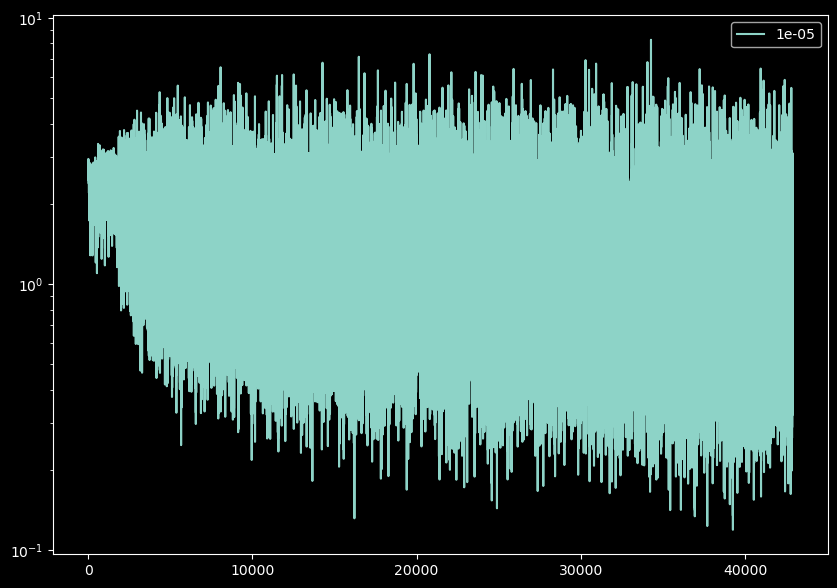

In [53]:
plt.figure(figsize=(10,7))
for r in R:
    plt.plot(r[0])
plt.yscale('log')
plt.legend([r[1] for r in R])


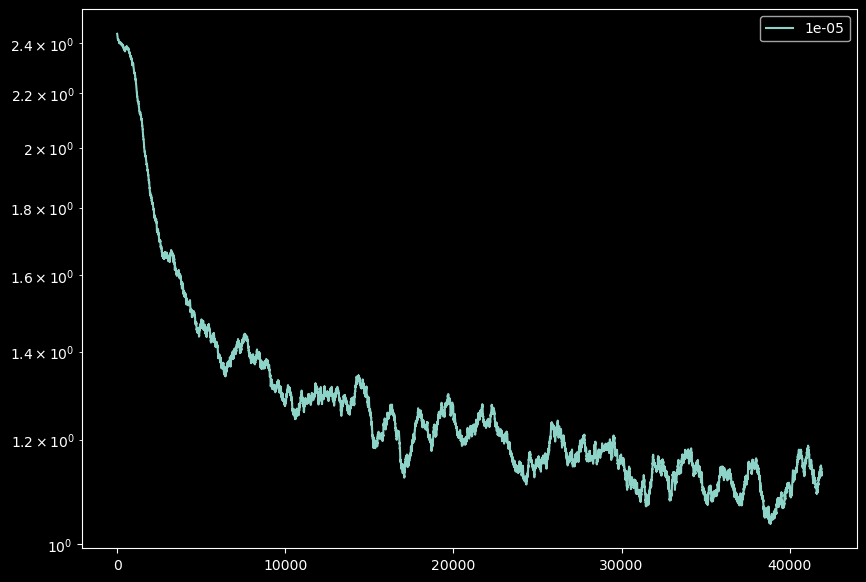

In [58]:
N=1000

plt.figure(figsize=(10,7))
for r in R:
    plt.plot(np.convolve(r[0], np.ones(N)/N, mode='valid'))
plt.yscale('log')
plt.legend([r[1] for r in R])

torch.Size([2, 389]) (2, 389, 1)


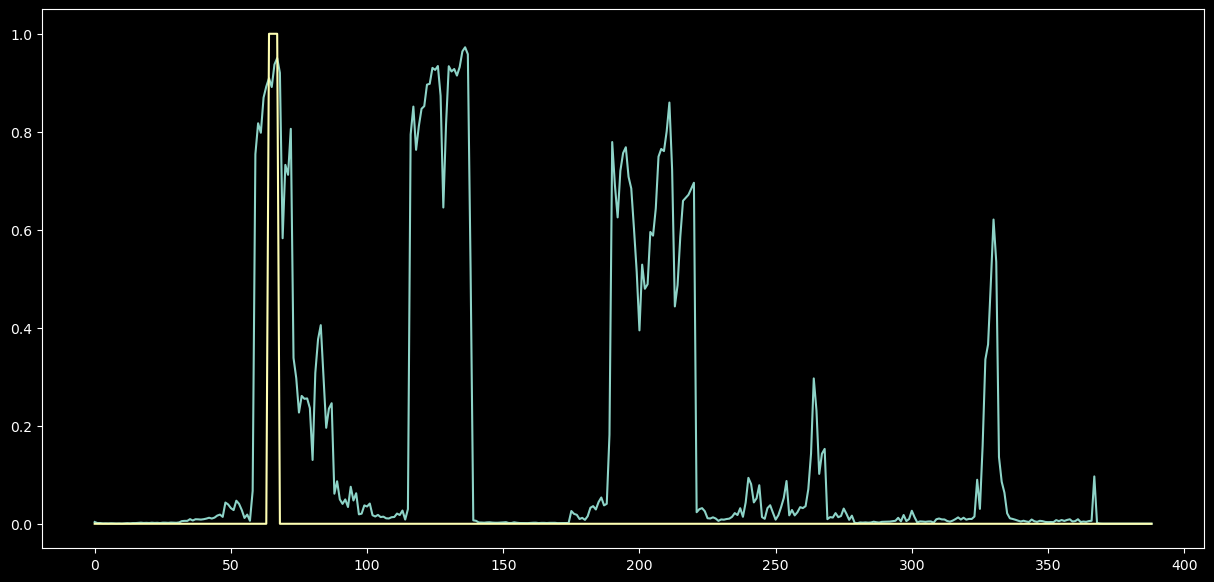

In [96]:
for batch_idx, data in enumerate(val_dataloader, 0):

    if batch_idx>0:
        break

    # get the inputs; data is a list of [inputs, labels]
    (passage_, question_), (sep_starts, sep_ends) = data

    #text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

    question = tokenizer(
                question_,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).to('cuda')

    passage = tokenizer(
                question_,
                passage_,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).to('cuda')
    
    pred = model.forward(   question.input_ids,
                            passage.input_ids,
                            question.attention_mask,
                            passage.attention_mask).detach().cpu().numpy()

    print(passage.input_ids.shape, pred.shape)

    y=torch.zeros(passage.input_ids.shape+(1,))

    for i in range(len(sep_starts)):
        
        start_tok=passage.char_to_token(i,sep_starts[i],1)
        end_tok=passage.char_to_token(i,sep_ends[i],1)

        if start_tok is None:
            start_tok=passage.char_to_token(i,sep_starts[i]+1,1)
        if start_tok is None:
            start_tok=passage.char_to_token(i,sep_starts[i]-1,1)

        if end_tok is None:
            end_tok=passage.char_to_token(i,sep_ends[i]-1,1)
        if end_tok is None:
            end_tok=passage.char_to_token(i,sep_ends[i]+1,1)
        
        y[i, start_tok : end_tok] = 1
    
    plt.figure(figsize=(15,7))
    plt.plot(pred[0])
    plt.plot(y[0])


In [61]:
model_name = 'distilroberta-base'

tokenizer=AutoTokenizer.from_pretrained(model_name)

In [62]:
model = InfoExtractor(model_name)
model.load_state_dict(torch.load('InfoExtractor1.pth'))
model = model.to('cuda')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializin

In [ ]:
model1 = InfoExtractor1(model_name)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model1.decoder.load_state_dict(model.decoder.state_dict())
model1 = model1.to('cuda')